Required libraries:

In [1]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sounddevice as sd
import soundfile as sf
import warnings
import random
from scipy.io import wavfile
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D, SimpleRNN, LSTM
from keras.models import Model
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

warnings.filterwarnings("ignore")

Data preprocessing:

Data from: https://www.kaggle.com/c/tensorflow-speech-recognition-challenge

In [ ]:
train_dataset = './input/'
labels = ['eight', 'nine', 'stop', 'wow', 'yes']
labels = os.listdir(train_dataset)
for label in labels:
    if not os.path.isdir(train_dataset + '/' + label):
        labels.remove(label)
labels.remove('_background_noise_')
chosen_labels = np.random.choice(labels, 5, replace=False)
print(chosen_labels)


['marvin' 'five' 'bed' 'stop' 'sheila']


In [3]:
train_dataset = './input'
chosen_labels = ['eight', 'nine', 'stop', 'wow', 'yes']
all_waves = []
all_labels = []
for label in chosen_labels:
    print("Preprocessing {}...".format(label))
    waves = [f for f in os.listdir(train_dataset + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_dataset + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(np.asarray(samples,dtype=np.float32), orig_sr=sample_rate, target_sr=8000)
        if(len(samples)== 8000) : 
            all_waves.append(samples)
            all_labels.append(label)

Preprocessing eight...
Preprocessing nine...
Preprocessing stop...
Preprocessing wow...
Preprocessing yes...


In [81]:
le = LabelEncoder()
y = le.fit_transform(all_labels)
classes = le.classes_

In [82]:
y = to_categorical(y, num_classes=len(chosen_labels))

In [83]:
X = np.array(all_waves).reshape(-1, 8000, 1)

In [84]:
print(X.shape)
print(y.shape)

(10141, 8000, 1)
(10141, 5)


In [85]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=777, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=666, shuffle=True)

print("X_train len", len(X_train))
print("X_val len", len(X_val))
print("X test len", len(X_test))

X_train len 8213
X_val len 913
X test len 1015


In [86]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)
print("X_val shape: ", X_test.shape)
print("y_val shape: ", y_test.shape)

X_train shape:  (8213, 8000, 1)
y_train shape:  (8213, 5)
X_val shape:  (913, 8000, 1)
y_val shape:  (913, 5)
X_val shape:  (1015, 8000, 1)
y_val shape:  (1015, 5)


Model

In [87]:
K.clear_session()

inputs = Input(shape=(8000, 1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(chosen_labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 7988, 8)        │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2652, 16)       │         1,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 876, 32)        │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 286, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6080)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,556,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,610,853 (6.14 MB)

 Trainable params: 1,610,853 (6.14 MB)

 Non-trainable params: 0 (0.00 B)

In [88]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
num_epoch = 30

In [89]:
history=model.fit(X_train, y_train ,epochs=num_epoch, callbacks=[es,mc], batch_size=32, validation_data=(X_val,y_val))

Epoch 1/30
256/257 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3188 - loss: 1.4888
Epoch 1: val_accuracy improved from -inf to 0.55969, saving model to best_model.hdf5.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - accuracy: 0.3195 - loss: 1.4876 - val_accuracy: 0.5597 - val_loss: 1.0495
Epoch 2/30
256/257 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5703 - loss: 1.0180
Epoch 2: val_accuracy improved from 0.55969 to 0.73823, saving model to best_model.hdf5.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.5708 - loss: 1.0173 - val_accuracy: 0.7382 - val_loss: 0.7911
Epoch 3/30
256/257 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7645 - loss: 0.6506
Epoch 3: val_accuracy did not improve from 0.73823
257/257 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.7646 - loss: 0.6502 - val_accuracy: 0.7130 - val_loss: 0.8006
Epoch 4/30
256/257 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8274 - loss: 0.4899
Epoch 4: val_accuracy improved from 0.73823 to 0.87185, sav

Results

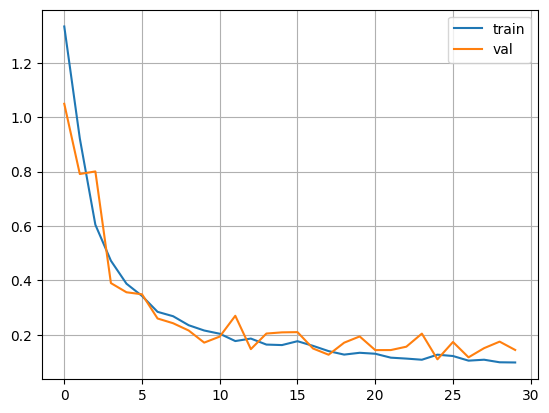

In [90]:
epochs = num_epoch # set num_epoch here or use another value based on training process
plt.figure()
plt.plot(range(epochs),history.history['loss'], label='train')
plt.plot(range(epochs),history.history['val_loss'], label='val')
plt.legend()
plt.grid()
plt.show()

Tests

In [91]:
model = load_model('best_model.hdf5.keras')

In [92]:
def predict(audio):
    prob=model.predict(audio.reshape(-1,8000,1))
    index=np.argmax(prob[0])
    return index, classes[index]

In [93]:
sample_l = []
predict_l = []
for idx in range(len(X_test)):
    samples=X_test[idx].ravel()
    predicted, _ = predict(samples)
    sample_l.append(int(np.argmax(y_test[idx])))
    predict_l.append(int(predicted))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

In [94]:
print("Sample list", sample_l)
print("Predict list", predict_l)

Sample list [0, 1, 0, 4, 3, 2, 4, 1, 1, 0, 2, 1, 2, 0, 1, 1, 2, 1, 1, 0, 4, 1, 0, 4, 2, 4, 4, 2, 1, 1, 4, 4, 1, 2, 0, 4, 0, 3, 0, 2, 1, 1, 3, 4, 3, 4, 1, 4, 4, 4, 0, 1, 1, 2, 4, 1, 2, 0, 1, 4, 2, 2, 4, 3, 0, 4, 0, 4, 4, 0, 0, 4, 0, 1, 1, 4, 0, 1, 0, 4, 3, 2, 1, 2, 2, 1, 4, 4, 2, 4, 0, 0, 3, 3, 0, 0, 2, 3, 1, 3, 2, 4, 4, 4, 1, 0, 4, 4, 4, 3, 1, 4, 3, 3, 4, 0, 1, 1, 1, 3, 2, 3, 4, 1, 0, 0, 2, 4, 1, 2, 4, 2, 2, 0, 2, 2, 2, 1, 1, 4, 1, 1, 3, 0, 4, 4, 2, 4, 4, 0, 2, 2, 1, 4, 4, 4, 2, 2, 1, 4, 2, 3, 2, 2, 2, 2, 0, 0, 4, 3, 4, 4, 4, 4, 1, 2, 1, 3, 4, 2, 0, 3, 4, 0, 0, 3, 0, 1, 4, 2, 2, 1, 4, 2, 2, 2, 0, 3, 1, 4, 0, 1, 1, 1, 1, 1, 1, 4, 4, 0, 2, 1, 3, 3, 2, 4, 1, 3, 0, 0, 3, 0, 3, 4, 4, 4, 4, 3, 4, 2, 0, 0, 3, 3, 2, 1, 3, 0, 1, 2, 2, 0, 3, 2, 0, 1, 3, 4, 3, 1, 3, 4, 3, 4, 3, 4, 4, 0, 0, 2, 2, 1, 3, 2, 0, 3, 4, 3, 1, 1, 1, 1, 0, 1, 3, 2, 0, 3, 0, 1, 1, 1, 2, 4, 2, 0, 0, 4, 2, 1, 2, 3, 1, 2, 0, 2, 2, 1, 2, 4, 4, 4, 0, 1, 1, 0, 4, 1, 3, 1, 2, 1, 2, 3, 2, 4, 1, 1, 4, 0, 0, 4, 2, 2, 0, 4, 3, 1, 0, 

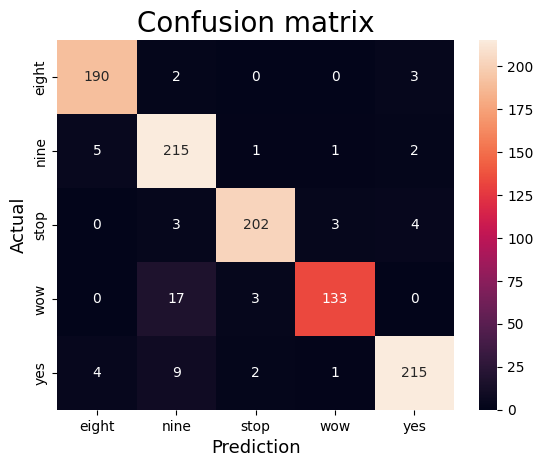

In [95]:
cm = confusion_matrix(sample_l, predict_l)

sns.heatmap(cm, annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.title('Confusion matrix', fontsize=20)
plt.xlabel('Prediction', fontsize=13)
plt.ylabel('Actual', fontsize=13)
plt.show()

In [96]:
print(classification_report(sample_l, predict_l, target_names=classes))

              precision    recall  f1-score   support

       eight       0.95      0.97      0.96       195
        nine       0.87      0.96      0.91       224
        stop       0.97      0.95      0.96       212
         wow       0.96      0.87      0.91       153
         yes       0.96      0.93      0.95       231

    accuracy                           0.94      1015
   macro avg       0.94      0.94      0.94      1015
weighted avg       0.94      0.94      0.94      1015



80% of training dataset

In [97]:
X_train_80 = X_train[:int(0.8 * len(X_train))]
y_train_80 = y_train[:int(0.8 * len(y_train))]
print("X_train len", len(X_train_80))
print("y_train len", len(y_train_80))

X_train len 6570
y_train len 6570


In [98]:
K.clear_session()

inputs = Input(shape=(8000, 1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(chosen_labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 7988, 8)        │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2652, 16)       │         1,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 876, 32)        │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 286, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6080)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,556,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,610,853 (6.14 MB)

 Trainable params: 1,610,853 (6.14 MB)

 Non-trainable params: 0 (0.00 B)

In [99]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model_80.hdf5.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
num_epoch = 30

In [100]:
history=model.fit(X_train_80, y_train_80 ,epochs=num_epoch, callbacks=[es,mc], batch_size=32, validation_data=(X_val,y_val))

Epoch 1/30
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3135 - loss: 1.5028
Epoch 1: val_accuracy improved from -inf to 0.60022, saving model to best_model_80.hdf5.keras
206/206 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.3144 - loss: 1.5015 - val_accuracy: 0.6002 - val_loss: 1.1405
Epoch 2/30
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6116 - loss: 1.0092
Epoch 2: val_accuracy improved from 0.60022 to 0.76232, saving model to best_model_80.hdf5.keras
206/206 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.6119 - loss: 1.0085 - val_accuracy: 0.7623 - val_loss: 0.7546
Epoch 3/30
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7466 - loss: 0.7017
Epoch 3: val_accuracy did not improve from 0.76232
206/206 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.7468 - loss: 0.7012 - val_accuracy: 0.6944 - val_loss: 1.0508
Epoch 4/30
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8053 - loss: 0.5440
Epoch 4: val_accuracy improved from 0.76232 to 0.8050

In [101]:
model = load_model('best_model_80.hdf5.keras')

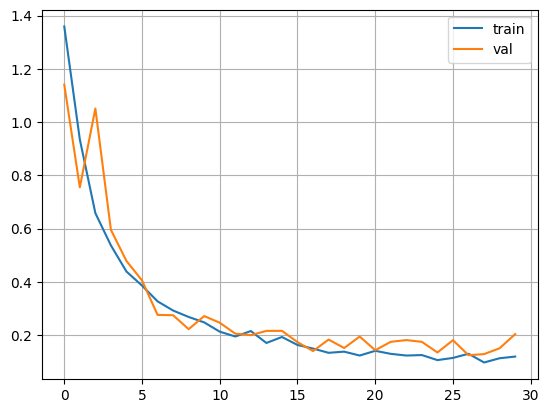

In [102]:
epochs = num_epoch
plt.figure()
plt.plot(range(epochs),history.history['loss'], label='train')
plt.plot(range(epochs),history.history['val_loss'], label='val')
plt.legend()
plt.grid()
plt.show()

In [103]:
sample_l = []
predict_l = []
for idx in range(len(X_test)):
    samples=X_test[idx].ravel()
    predicted, _ = predict(samples)
    sample_l.append(int(np.argmax(y_test[idx])))
    predict_l.append(int(predicted))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

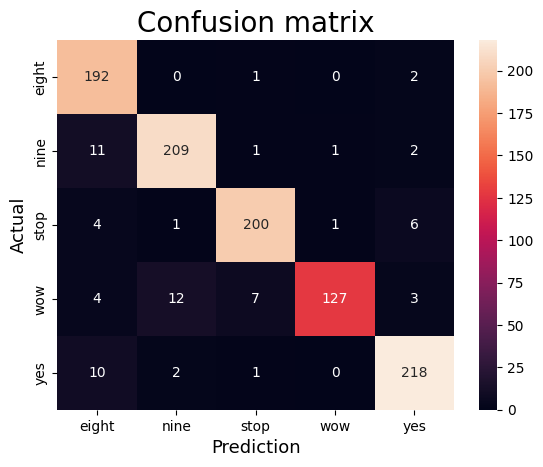

In [104]:
cm = confusion_matrix(sample_l, predict_l)

sns.heatmap(cm, annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.title('Confusion matrix', fontsize=20)
plt.xlabel('Prediction', fontsize=13)
plt.ylabel('Actual', fontsize=13)
plt.show()

In [105]:
print(classification_report(sample_l, predict_l, target_names=classes))

              precision    recall  f1-score   support

       eight       0.87      0.98      0.92       195
        nine       0.93      0.93      0.93       224
        stop       0.95      0.94      0.95       212
         wow       0.98      0.83      0.90       153
         yes       0.94      0.94      0.94       231

    accuracy                           0.93      1015
   macro avg       0.94      0.93      0.93      1015
weighted avg       0.93      0.93      0.93      1015



60% of training dataset

In [106]:
X_train_60 = X_train[:int(0.6 * len(X_train))]
y_train_60 = y_train[:int(0.6 * len(y_train))]
print("X_train len", len(X_train_60))
print("y_train len", len(y_train_60))

X_train len 4927
y_train len 4927


In [107]:
K.clear_session()

inputs = Input(shape=(8000, 1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(chosen_labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 7988, 8)        │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2652, 16)       │         1,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 876, 32)        │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 286, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6080)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,556,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,610,853 (6.14 MB)

 Trainable params: 1,610,853 (6.14 MB)

 Non-trainable params: 0 (0.00 B)

In [108]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model_60.hdf5.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
num_epoch = 30

In [109]:
history=model.fit(X_train_60, y_train_60, epochs=num_epoch, callbacks=[es,mc], batch_size=32, validation_data=(X_val,y_val))

Epoch 1/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2855 - loss: 1.5470
Epoch 1: val_accuracy improved from -inf to 0.52136, saving model to best_model_60.hdf5.keras
154/154 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.2860 - loss: 1.5463 - val_accuracy: 0.5214 - val_loss: 1.2000
Epoch 2/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5522 - loss: 1.1258
Epoch 2: val_accuracy improved from 0.52136 to 0.72837, saving model to best_model_60.hdf5.keras
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.5525 - loss: 1.1252 - val_accuracy: 0.7284 - val_loss: 0.7576
Epoch 3/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7206 - loss: 0.7557
Epoch 3: val_accuracy improved from 0.72837 to 0.82694, saving model to best_model_60.hdf5.keras
154/154 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.7208 - loss: 0.7554 - val_accuracy: 0.8269 - val_loss: 0.5593
Epoch 4/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7871 - loss: 0.5935
Epoch 4:

In [110]:
model = load_model('best_model_60.hdf5.keras')

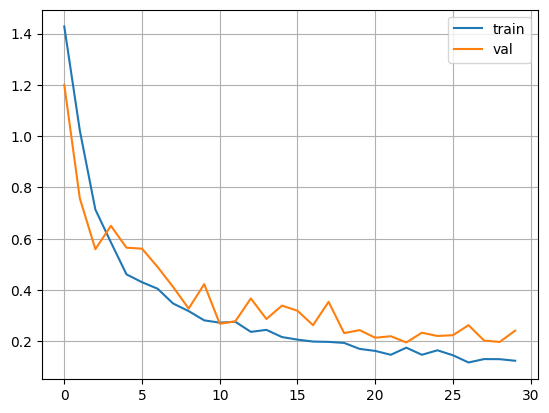

In [111]:
epochs = num_epoch
plt.figure()
plt.plot(range(epochs),history.history['loss'], label='train')
plt.plot(range(epochs),history.history['val_loss'], label='val')
plt.legend()
plt.grid()
plt.show()

In [112]:
def predict(audio):
    prob=model.predict(audio.reshape(-1,8000,1))
    index=np.argmax(prob[0])
    return index, classes[index]

In [113]:
sample_l = []
predict_l = []
for idx in range(len(X_test)):
    samples=X_test[idx].ravel()
    predicted, _ = predict(samples)
    sample_l.append(int(np.argmax(y_test[idx])))
    predict_l.append(int(predicted))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━

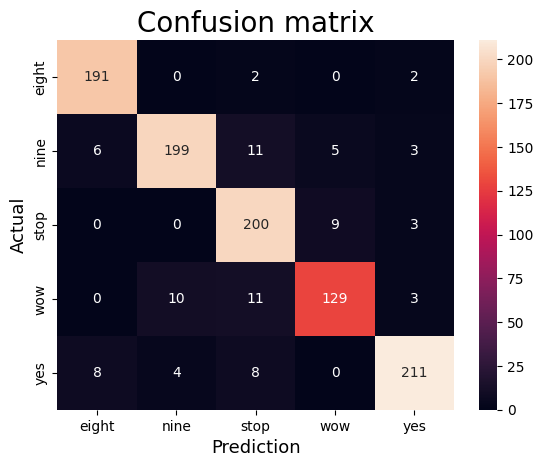

In [114]:
cm = confusion_matrix(sample_l, predict_l)

sns.heatmap(cm, annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.title('Confusion matrix', fontsize=20)
plt.xlabel('Prediction', fontsize=13)
plt.ylabel('Actual', fontsize=13)
plt.show()

In [115]:
print(classification_report(sample_l, predict_l, target_names=classes))

              precision    recall  f1-score   support

       eight       0.93      0.98      0.95       195
        nine       0.93      0.89      0.91       224
        stop       0.86      0.94      0.90       212
         wow       0.90      0.84      0.87       153
         yes       0.95      0.91      0.93       231

    accuracy                           0.92      1015
   macro avg       0.92      0.91      0.91      1015
weighted avg       0.92      0.92      0.92      1015



40% of training dataset

In [116]:
X_train_40 = X_train[:int(0.4 * len(X_train))]
y_train_40 = y_train[:int(0.4 * len(y_train))]
print("X_train len", len(X_train_40))
print("y_train len", len(y_train_40))

X_train len 3285
y_train len 3285


In [117]:
K.clear_session()

inputs = Input(shape=(8000, 1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(chosen_labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 7988, 8)        │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2652, 16)       │         1,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 876, 32)        │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 286, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6080)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,556,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,610,853 (6.14 MB)

 Trainable params: 1,610,853 (6.14 MB)

 Non-trainable params: 0 (0.00 B)

In [118]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model_40.hdf5.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
num_epoch = 30

In [119]:
history=model.fit(X_train_40, y_train_40 ,epochs=num_epoch, callbacks=[es,mc], batch_size=32, validation_data=(X_val,y_val))

Epoch 1/30
102/103 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2655 - loss: 1.5878
Epoch 1: val_accuracy improved from -inf to 0.35049, saving model to best_model_40.hdf5.keras
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.2664 - loss: 1.5867 - val_accuracy: 0.3505 - val_loss: 1.5053
Epoch 2/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5234 - loss: 1.1715
Epoch 2: val_accuracy improved from 0.35049 to 0.66813, saving model to best_model_40.hdf5.keras
103/103 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.5239 - loss: 1.1706 - val_accuracy: 0.6681 - val_loss: 0.8964
Epoch 3/30
102/103 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6571 - loss: 0.8687
Epoch 3: val_accuracy improved from 0.66813 to 0.70099, saving model to best_model_40.hdf5.keras
103/103 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.6575 - loss: 0.8683 - val_accuracy: 0.7010 - val_loss: 0.7684
Epoch 4/30
102/103 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7410 - loss: 0.6887
Epoch 4: v

In [120]:
model = load_model('best_model_40.hdf5.keras')

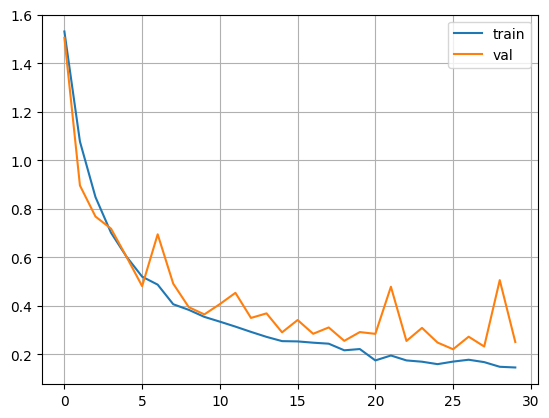

In [121]:
epochs = num_epoch
plt.figure()
plt.plot(range(epochs),history.history['loss'], label='train')
plt.plot(range(epochs),history.history['val_loss'], label='val')
plt.legend()
plt.grid()
plt.show()

In [122]:
def predict(audio):
    prob=model.predict(audio.reshape(-1,8000,1))
    index=np.argmax(prob[0])
    return index, classes[index]

In [123]:
sample_l = []
predict_l = []
for idx in range(len(X_test)):
    samples=X_test[idx].ravel()
    predicted, _ = predict(samples)
    sample_l.append(int(np.argmax(y_test[idx])))
    predict_l.append(int(predicted))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━

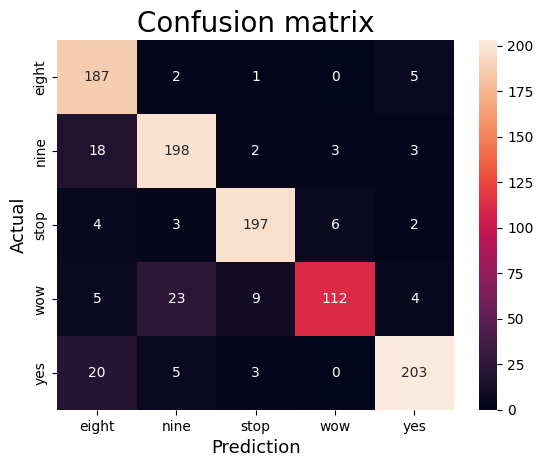

In [124]:
cm = confusion_matrix(sample_l, predict_l)

sns.heatmap(cm, annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.title('Confusion matrix', fontsize=20)
plt.xlabel('Prediction', fontsize=13)
plt.ylabel('Actual', fontsize=13)
plt.show()

In [125]:
print(classification_report(sample_l, predict_l, target_names=classes))

              precision    recall  f1-score   support

       eight       0.80      0.96      0.87       195
        nine       0.86      0.88      0.87       224
        stop       0.93      0.93      0.93       212
         wow       0.93      0.73      0.82       153
         yes       0.94      0.88      0.91       231

    accuracy                           0.88      1015
   macro avg       0.89      0.88      0.88      1015
weighted avg       0.89      0.88      0.88      1015



20% of training dataset

In [126]:
X_train_20 = X_train[:int(0.2 * len(X_train))]
y_train_20 = y_train[:int(0.2 * len(y_train))]
print("X_train len", len(X_train_20))
print("y_train len", len(y_train_20))

X_train len 1642
y_train len 1642


In [127]:
K.clear_session()

inputs = Input(shape=(8000, 1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(chosen_labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 7988, 8)        │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2652, 16)       │         1,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 876, 32)        │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 286, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6080)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,556,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,610,853 (6.14 MB)

 Trainable params: 1,610,853 (6.14 MB)

 Non-trainable params: 0 (0.00 B)

In [128]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model_20.hdf5.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
num_epoch = 30

In [129]:
history=model.fit(X_train_20, y_train_20 ,epochs=num_epoch, callbacks=[es,mc], batch_size=32, validation_data=(X_val,y_val))

Epoch 1/30
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2544 - loss: 1.6037
Epoch 1: val_accuracy improved from -inf to 0.32311, saving model to best_model_20.hdf5.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.2547 - loss: 1.6034 - val_accuracy: 0.3231 - val_loss: 1.5767
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3180 - loss: 1.5265
Epoch 2: val_accuracy improved from 0.32311 to 0.42716, saving model to best_model_20.hdf5.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.3185 - loss: 1.5260 - val_accuracy: 0.4272 - val_loss: 1.3914
Epoch 3/30
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4269 - loss: 1.3400
Epoch 3: val_accuracy improved from 0.42716 to 0.62541, saving model to best_model_20.hdf5.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.4289 - loss: 1.3369 - val_accuracy: 0.6254 - val_loss: 1.0464
Epoch 4/30
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5743 - loss: 1.0641
Epoch 4: val_accuracy im

In [130]:
model = load_model('best_model_20.hdf5.keras')

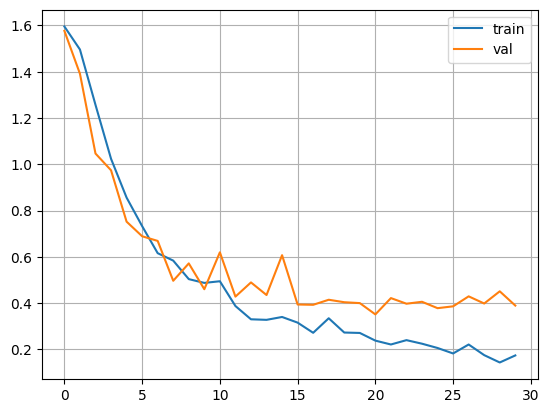

In [131]:
epochs = num_epoch
plt.figure()
plt.plot(range(epochs),history.history['loss'], label='train')
plt.plot(range(epochs),history.history['val_loss'], label='val')
plt.legend()
plt.grid()
plt.show()

In [132]:
def predict(audio):
    prob=model.predict(audio.reshape(-1,8000,1))
    index=np.argmax(prob[0])
    return index, classes[index]

In [133]:
sample_l = []
predict_l = []
for idx in range(len(X_test)):
    samples=X_test[idx].ravel()
    predicted, _ = predict(samples)
    sample_l.append(int(np.argmax(y_test[idx])))
    predict_l.append(int(predicted))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

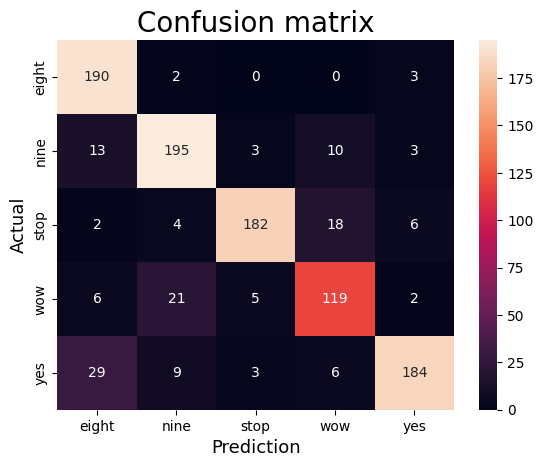

In [134]:
cm = confusion_matrix(sample_l, predict_l)

sns.heatmap(cm, annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.title('Confusion matrix', fontsize=20)
plt.xlabel('Prediction', fontsize=13)
plt.ylabel('Actual', fontsize=13)
plt.show()

In [135]:
print(classification_report(sample_l, predict_l, target_names=classes))

              precision    recall  f1-score   support

       eight       0.79      0.97      0.87       195
        nine       0.84      0.87      0.86       224
        stop       0.94      0.86      0.90       212
         wow       0.78      0.78      0.78       153
         yes       0.93      0.80      0.86       231

    accuracy                           0.86      1015
   macro avg       0.86      0.86      0.85      1015
weighted avg       0.86      0.86      0.86      1015



| Rozmiar datasetu | Dokładność |
|------------|------------|
| 100%   | 94%    |
| 80%   | 93%    |
| 60%   | 92%    |
| 40%   | 89%    |
| 20%   | 86%   |

Data augmentation

In [236]:
train_dataset = './input/'
labels = os.listdir(train_dataset)
for label in labels:
    if not os.path.isdir(train_dataset + '/' + label):
        labels.remove(label)
labels.remove('_background_noise_')
chosen_labels = ['eight', 'nine', 'stop', 'wow', 'yes']
new_labels = []
while len(new_labels) != 5:
    r_label = str(np.random.choice(labels))
    if r_label not in chosen_labels and r_label not in new_labels:
        new_labels.append(r_label)

print("New labels: ", new_labels)
print("Chosen labels: ", chosen_labels)

New labels:  ['left', 'sheila', 'up', 'house', 'five']
Chosen labels:  ['eight', 'nine', 'stop', 'wow', 'yes']


In [237]:
train_dataset = './input/'
all_waves = []
all_labels = []
for label in new_labels:
    print("Preprocessing {}...".format(label))
    waves = [f for f in os.listdir(train_dataset + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_dataset + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(np.asarray(samples,dtype=np.float32), orig_sr=sample_rate, target_sr=8000)
        if(len(samples)== 8000) : 
            all_waves.append(samples)
            all_labels.append(label)

Preprocessing left...
Preprocessing sheila...
Preprocessing up...
Preprocessing house...
Preprocessing five...


In [287]:
le = LabelEncoder()
y = le.fit_transform(all_labels)
classes = le.classes_
print(y.shape)

(9526,)


In [288]:
y = to_categorical(y, num_classes=len(new_labels))

In [289]:
X = np.array(all_waves).reshape(-1, 8000, 1)

In [290]:
print(X.shape)
print(y.shape)


(9526, 8000, 1)
(9526, 5)


In [291]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=777, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=666, shuffle=True)

print("X_train len", len(X_train))
print("X_val len", len(X_val))
print("X test len", len(X_test))

X_train len 7715
X_val len 858
X test len 953


In [292]:
X_train = X_train[:int(0.2 * len(X_train))]
y_train = y_train[:int(0.2 * len(y_train))]
print("X_train len", len(X_train))
print("y_train len", len(y_train))

original_size = y_train.shape[0]

X_train len 1543
y_train len 1543


In [293]:
K.clear_session()

inputs = Input(shape=(8000, 1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(chosen_labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 7988, 8)        │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2652, 16)       │         1,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 876, 32)        │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 286, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6080)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,556,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,610,853 (6.14 MB)

 Trainable params: 1,610,853 (6.14 MB)

 Non-trainable params: 0 (0.00 B)

In [294]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model_without_aug.hdf5.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
num_epoch = 30

In [295]:
history=model.fit(X_train, y_train ,epochs=num_epoch, callbacks=[es,mc], batch_size=32, validation_data=(X_val,y_val))

Epoch 1/30
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2582 - loss: 1.5906
Epoch 1: val_accuracy improved from -inf to 0.25408, saving model to best_model_without_aug.hdf5.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.2594 - loss: 1.5900 - val_accuracy: 0.2541 - val_loss: 1.5724
Epoch 2/30
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3027 - loss: 1.5346
Epoch 2: val_accuracy improved from 0.25408 to 0.28555, saving model to best_model_without_aug.hdf5.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.3034 - loss: 1.5335 - val_accuracy: 0.2855 - val_loss: 1.5105
Epoch 3/30
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4164 - loss: 1.4159
Epoch 3: val_accuracy improved from 0.28555 to 0.44056, saving model to best_model_without_aug.hdf5.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.4174 - loss: 1.4146 - val_accuracy: 0.4406 - val_loss: 1.3184
Epoch 4/30
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4713 - loss: 1.31

In [296]:
model = load_model('best_model_without_aug.hdf5.keras')

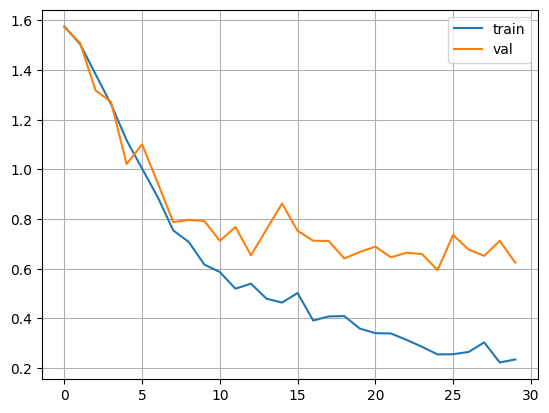

In [297]:
epochs = num_epoch
plt.figure()
plt.plot(range(epochs),history.history['loss'], label='train')
plt.plot(range(epochs),history.history['val_loss'], label='val')
plt.legend()
plt.grid()
plt.show()

In [298]:
def predict(audio):
    prob=model.predict(audio.reshape(-1,8000,1))
    index=np.argmax(prob[0])
    return index, classes[index]

In [299]:
sample_l = []
predict_l = []
for idx in range(len(X_test)):
    samples=X_test[idx].ravel()
    predicted, _ = predict(samples)
    sample_l.append(int(np.argmax(y_test[idx])))
    predict_l.append(int(predicted))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

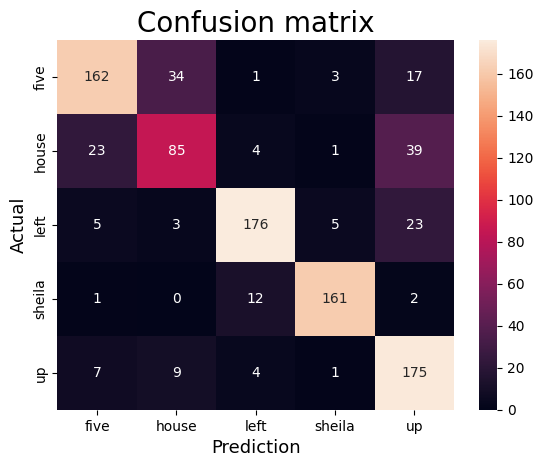

In [300]:
cm = confusion_matrix(sample_l, predict_l)

sns.heatmap(cm, annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.title('Confusion matrix', fontsize=20)
plt.xlabel('Prediction', fontsize=13)
plt.ylabel('Actual', fontsize=13)
plt.show()

In [301]:
print(classification_report(sample_l, predict_l, target_names=classes))

              precision    recall  f1-score   support

        five       0.82      0.75      0.78       217
       house       0.65      0.56      0.60       152
        left       0.89      0.83      0.86       212
      sheila       0.94      0.91      0.93       176
          up       0.68      0.89      0.77       196

    accuracy                           0.80       953
   macro avg       0.80      0.79      0.79       953
weighted avg       0.80      0.80      0.80       953



In [257]:
# Data augmentation HERE

new_size = original_size * 2
X_augmented = np.zeros((new_size, *X_train.shape[1:]))
y_augmented = np.zeros((new_size, *y_train.shape[1:]))

X_augmented[:original_size] = X_train
y_augmented[:original_size] = y_train

noise = 0.01 * np.random.randn(original_size, *X_train.shape[1:])
X_augmented[original_size:] = X_train + noise
y_augmented[original_size:] = y_train

X_train, y_train = X_augmented, y_augmented


In [258]:
print(X_train.shape)
print(y_train.shape)

(3086, 8000, 1)
(3086, 5)


In [259]:
idx = np.random.randint(original_size, 2*original_size)
samples=X_train[idx].ravel()
print("Audio:",classes[np.argmax(y_train[idx])])
ipd.Audio(samples, rate=8000)

Audio: five


In [260]:
new_size = original_size * 3
X_augmented = np.zeros((new_size, *X_train.shape[1:]))
y_augmented = np.zeros((new_size, *y_train.shape[1:]))

X_augmented[:2*original_size] = X_train
y_augmented[:2*original_size] = y_train

shift = 500
X_augmented[original_size:] = np.roll(X_train, shift)
y_augmented[original_size:] = y_train

X_train, y_train = X_augmented, y_augmented


In [261]:
print(X_train.shape)
print(y_train.shape)

(4629, 8000, 1)
(4629, 5)


In [262]:
idx = np.random.randint(2*original_size, 3*original_size)
samples=X_train[idx].ravel()
print("Audio:",classes[np.argmax(y_train[idx])])
ipd.Audio(samples, rate=8000)

Audio: left


In [263]:
K.clear_session()

inputs = Input(shape=(8000, 1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(chosen_labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 7988, 8)        │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2652, 16)       │         1,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 876, 32)        │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 286, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6080)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,556,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,610,853 (6.14 MB)

 Trainable params: 1,610,853 (6.14 MB)

 Non-trainable params: 0 (0.00 B)

In [264]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model_aug.hdf5.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
num_epoch = 30

In [265]:
history=model.fit(X_train, y_train ,epochs=num_epoch, callbacks=[es,mc], batch_size=32, validation_data=(X_val,y_val))

Epoch 1/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.2787 - loss: 1.5648
Epoch 1: val_accuracy improved from -inf to 0.41026, saving model to best_model_aug.hdf5.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.2790 - loss: 1.5644 - val_accuracy: 0.4103 - val_loss: 1.3552
Epoch 2/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4417 - loss: 1.2798
Epoch 2: val_accuracy improved from 0.41026 to 0.59557, saving model to best_model_aug.hdf5.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.4422 - loss: 1.2791 - val_accuracy: 0.5956 - val_loss: 1.0093
Epoch 3/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6386 - loss: 0.9278
Epoch 3: val_accuracy improved from 0.59557 to 0.71795, saving model to best_model_aug.hdf5.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.6389 - loss: 0.9273 - val_accuracy: 0.7179 - val_loss: 0.7538
Epoch 4/30
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7278 - loss: 0.7049
Epoc

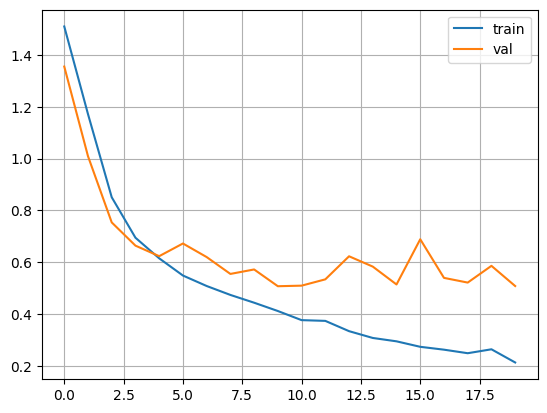

In [267]:
epochs = 20
plt.figure()
plt.plot(range(epochs),history.history['loss'], label='train')
plt.plot(range(epochs),history.history['val_loss'], label='val')
plt.legend()
plt.grid()
plt.show()

In [268]:
model = load_model('best_model_aug.hdf5.keras')

In [269]:
def predict(audio):
    prob=model.predict(audio.reshape(-1,8000,1))
    index=np.argmax(prob[0])
    return index, classes[index]

In [270]:
sample_l = []
predict_l = []
for idx in range(len(X_test)):
    samples=X_test[idx].ravel()
    predicted, _ = predict(samples)
    sample_l.append(int(np.argmax(y_test[idx])))
    predict_l.append(int(predicted))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

In [271]:
print(sample_l)
print(predict_l)

[1, 2, 3, 4, 3, 2, 2, 2, 0, 3, 3, 2, 0, 0, 2, 2, 2, 0, 0, 4, 0, 4, 4, 0, 3, 0, 2, 4, 0, 0, 0, 0, 4, 2, 4, 2, 4, 4, 0, 4, 4, 2, 4, 2, 0, 1, 1, 2, 4, 4, 1, 0, 4, 0, 2, 0, 3, 1, 2, 3, 2, 3, 4, 1, 3, 1, 0, 0, 0, 2, 1, 3, 2, 0, 2, 1, 0, 2, 4, 4, 2, 4, 3, 1, 3, 3, 2, 3, 4, 3, 0, 2, 1, 1, 1, 4, 4, 4, 3, 1, 2, 3, 4, 3, 2, 0, 2, 2, 0, 2, 0, 1, 0, 2, 0, 4, 0, 1, 4, 0, 1, 0, 0, 2, 4, 0, 2, 2, 4, 1, 2, 0, 2, 3, 2, 2, 2, 0, 3, 2, 3, 2, 2, 4, 1, 2, 3, 0, 2, 3, 2, 0, 2, 3, 4, 3, 4, 0, 4, 2, 1, 4, 3, 1, 3, 1, 3, 0, 2, 3, 4, 0, 4, 3, 3, 4, 0, 2, 1, 2, 4, 0, 0, 0, 0, 2, 2, 0, 0, 0, 4, 3, 2, 2, 1, 4, 4, 3, 4, 4, 1, 2, 2, 2, 4, 0, 2, 0, 0, 1, 1, 3, 3, 0, 2, 0, 3, 4, 4, 1, 2, 2, 0, 2, 1, 0, 4, 2, 3, 3, 3, 3, 0, 3, 0, 1, 3, 4, 1, 1, 2, 3, 3, 1, 1, 2, 0, 0, 4, 3, 2, 0, 4, 0, 1, 0, 0, 4, 2, 4, 2, 2, 3, 1, 2, 4, 1, 3, 2, 2, 0, 4, 3, 2, 0, 4, 4, 2, 4, 2, 2, 2, 2, 2, 4, 1, 0, 2, 0, 4, 3, 2, 4, 2, 3, 4, 0, 0, 4, 3, 4, 1, 4, 1, 4, 3, 0, 3, 1, 2, 3, 0, 1, 3, 2, 1, 3, 2, 4, 1, 2, 0, 4, 1, 2, 4, 3, 3, 3, 1, 3, 0, 2, 

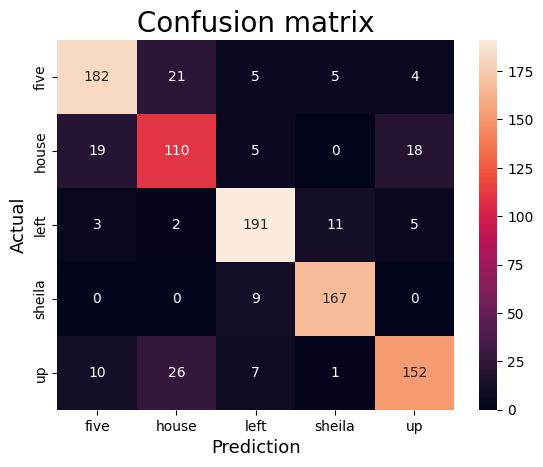

In [272]:
cm = confusion_matrix(sample_l, predict_l)

sns.heatmap(cm, annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.title('Confusion matrix', fontsize=20)
plt.xlabel('Prediction', fontsize=13)
plt.ylabel('Actual', fontsize=13)
plt.show()

In [273]:
print(classification_report(sample_l, predict_l, target_names=classes))

              precision    recall  f1-score   support

        five       0.85      0.84      0.84       217
       house       0.69      0.72      0.71       152
        left       0.88      0.90      0.89       212
      sheila       0.91      0.95      0.93       176
          up       0.85      0.78      0.81       196

    accuracy                           0.84       953
   macro avg       0.84      0.84      0.84       953
weighted avg       0.84      0.84      0.84       953



ConvNet - deeper architecture

In [302]:
train_dataset = './input/'
chosen_labels = ['eight', 'nine', 'stop', 'wow', 'yes']

In [303]:
all_waves = []
all_labels = []
for label in chosen_labels:
    print("Preprocessing {}...".format(label))
    waves = [f for f in os.listdir(train_dataset + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_dataset + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(np.asarray(samples,dtype=np.float32), orig_sr=sample_rate, target_sr=8000)
        if(len(samples)== 8000) : 
            all_waves.append(samples)
            all_labels.append(label)

Preprocessing eight...
Preprocessing nine...
Preprocessing stop...
Preprocessing wow...
Preprocessing yes...


In [335]:
le = LabelEncoder()
y = le.fit_transform(all_labels)
classes = le.classes_

In [336]:
y = to_categorical(y, num_classes=len(chosen_labels))

In [337]:
X = np.array(all_waves).reshape(-1, 8000, 1)

In [338]:
print(X.shape)
print(y.shape)

(10141, 8000, 1)
(10141, 5)


In [339]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=777, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=666, shuffle=True)

print("X_train len", len(X_train))
print("X_val len", len(X_val))
print("X test len", len(X_test))

X_train len 8213
X_val len 913
X test len 1015


In [340]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)
print("X_val shape: ", X_test.shape)
print("y_val shape: ", y_test.shape)

X_train shape:  (8213, 8000, 1)
y_train shape:  (8213, 5)
X_val shape:  (913, 8000, 1)
y_val shape:  (913, 5)
X_val shape:  (1015, 8000, 1)
y_val shape:  (1015, 5)


In [344]:
K.clear_session()

inputs = Input(shape=(8000, 1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fifth and sixth added Conv1D layer
conv = Conv1D(128, 5, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

conv = Conv1D(128, 5, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Seventh  added Conv1D layer
conv = Conv1D(256, 3, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)


#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(chosen_labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 7988, 8)        │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2652, 16)       │         1,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 876, 32)        │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 286, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 91, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 26, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 6, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             

 Total params: 407,141 (1.55 MB)

 Trainable params: 407,141 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

In [345]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model_deeper.hdf5.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
num_epoch = 30

In [346]:
history=model.fit(X_train, y_train ,epochs=num_epoch, callbacks=[es,mc], batch_size=32, validation_data=(X_val,y_val))

Epoch 1/30
256/257 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2539 - loss: 1.5665
Epoch 1: val_accuracy improved from -inf to 0.60022, saving model to best_model_deeper.hdf5.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.2545 - loss: 1.5656 - val_accuracy: 0.6002 - val_loss: 1.0145
Epoch 2/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6507 - loss: 0.9480
Epoch 2: val_accuracy improved from 0.60022 to 0.76123, saving model to best_model_deeper.hdf5.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.6509 - loss: 0.9475 - val_accuracy: 0.7612 - val_loss: 0.6286
Epoch 3/30
256/257 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7891 - loss: 0.6121
Epoch 3: val_accuracy improved from 0.76123 to 0.82913, saving model to best_model_deeper.hdf5.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.7893 - loss: 0.6116 - val_accuracy: 0.8291 - val_loss: 0.5008
Epoch 4/30
256/257 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8343 - loss: 0.

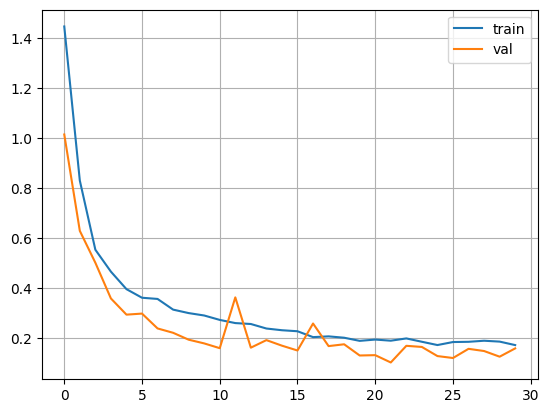

In [347]:
epochs = num_epoch
plt.figure()
plt.plot(range(epochs),history.history['loss'], label='train')
plt.plot(range(epochs),history.history['val_loss'], label='val')
plt.legend()
plt.grid()
plt.show()

In [348]:
model = load_model('best_model_deeper.hdf5.keras')

In [349]:
def predict(audio):
    prob=model.predict(audio.reshape(-1,8000,1))
    index=np.argmax(prob[0])
    return index, classes[index]

In [350]:
sample_l = []
predict_l = []
for idx in range(len(X_test)):
    samples=X_test[idx].ravel()
    predicted, _ = predict(samples)
    sample_l.append(int(np.argmax(y_test[idx])))
    predict_l.append(int(predicted))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━

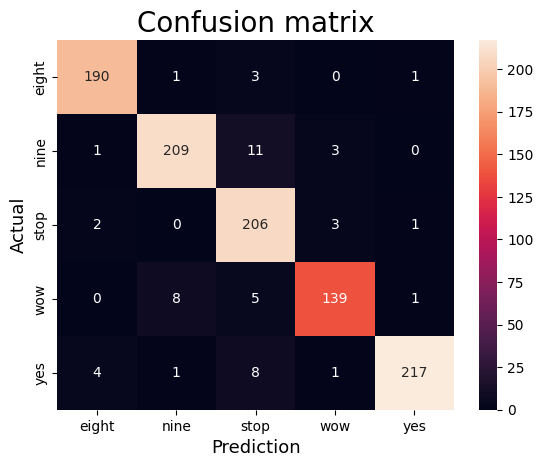

In [351]:
cm = confusion_matrix(sample_l, predict_l)

sns.heatmap(cm, annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.title('Confusion matrix', fontsize=20)
plt.xlabel('Prediction', fontsize=13)
plt.ylabel('Actual', fontsize=13)
plt.show()

In [352]:
print(classification_report(sample_l, predict_l, target_names=classes))

              precision    recall  f1-score   support

       eight       0.96      0.97      0.97       195
        nine       0.95      0.93      0.94       224
        stop       0.88      0.97      0.93       212
         wow       0.95      0.91      0.93       153
         yes       0.99      0.94      0.96       231

    accuracy                           0.95      1015
   macro avg       0.95      0.95      0.95      1015
weighted avg       0.95      0.95      0.95      1015

